- Convolution operations in one and two dimensions;
- The building blocks of CNN architectures;
- Implementing deep CNNs in PyTorch;
- Data augmentation techniques for improving the generalization performance;
- Implementing a facial CNN classifier for recognizing if someone is smiling or not.

# CNNs

Certain types of NNs, such as CNNs, can automatically learn the features from raw data that are most useful for a
particular task. For this reason, it's common to consider CNN layers as feature extractors: the early layers extract low
level features from raw data, while the later layers use these features to predict a continuous target value or class
label.

The local patch of pixels of a CNN is referred to as the local receptive field.

CNNs will usually perform very well on image-related tasks, and that's largely due to two important ideas:
- sparse connectivity: a single element in the feature map is connected to only a small patch of pixels;
- parameter sharing: the same weights are used for different pathces of the input image.

This decreases, conventionally, the number of weights.

Typically, CNNs are composed of several convolutional and subsampling layers (pooling layers) that are followed by one
or more fully connected layers at the end.

## Performing discrete convolutions

A discrete convolution (or convolution) is a fundamental operation in a CNN.

A discrete convolution for two vectors, $x$ and $w$, is denoted by $y = x * w$, in which $x$ is our input (sometimes
called signal) and $w$ is called the _filter_ or _kernel_. A discrete convolution is mathematically defined as follows:
$$y=x*w\rightarrow y[i]=\sum_{k=-\infty}^{+\infty}x[i-k]w[k]$$

The brackets, [], are used to denote the indexing for vector elements. The index, $i$, runs through each element of the
output vector, $y$. The fact that the sum runs through indices from $-\infty$ to $+\infty$ seems odd, mainly because in
machine learning applications, we always deal with finite feature vectors. Therefore, to correctly compute the summation
shown in the preceding formula, it is assumed that $x$ and $w$ are filled with zeros. This will result in an output
vector, $y$, that also has infinite size, with lots of zeros as well. Since this is not useful in practical solutions,
$x$ is padded only with a finite number of zeros.

This process is called _zero-padding_ or simply _padding_.

Let's assume that the original input, $x$, and filter, $w$, have $n$ and $m$ elements, respectively, where $m\leq n$.
Therefore, the padded vector, $x^p$, has size $n+2p$. The practical formula for computing a discrete convolution will
change to the following:
$$y=x*w\rightarrow y[i]=\sum_{k=0}^{m-1}x^p[i+m-k]w[k]$$


Now that we have solved the infinite index issue, the second issue is indexing $x$ with $y+m-k$. Computing the sum with
one index going in the reverse direction is equivalent to computing the sum with both indices in the forward direction
after flipping one of the vectors, after they were padded.

Let's assume we flip the filter, $w$, to the rotated filter, $w^r$. Then, the dot product, $x[i:i+m]\cdot w^r$, is
computed to get one element, $y[i]$, where $x[i:i+m]$ is a patch of $x$ with size $m$. This operation is repeated like
in a sliding window approach to get all the output elements.

Another hyperparameter of a convolution, other than the padding, is the _stride_, that explicits the number of cells to
shift at every step of the computation.

## Padding inputs to control the size of the output feature maps

Consider an example where $n=5$ and $m=3$. Then, with padding ($p$) = 0, $x[0]$ is only used in computing one output
element. So, you can see that this different treatment of elements of $x$ can artificially put more emphasis on the
middle element, $x[2]$, since it has appeared in most computations. We can avoid this issue if we choose $p=2$.

Furthermore, the size of the output, $y$, also depends on the choice of the padding strategy we use.

There are thre modes of padding that are commonly used: _full, same_ and _valid_.

In full mode, the padding parameter, $p$, is set to $p=m-1$. Full padding increases the dimensions of the output (thus,
rarely used in CNN architectures).

The same padding is usually used to ensure that the output vector has the same size as the input vector, $x$. In this
case, the $p$ is computed according to the filter size.

Finally, computing a convolution in valid mode refers to the case where $p=0$ (no padding).

**NOTE**: one big disadvantage of valid padding versus full and same padding is that the volume of the tensors will
decrease substantially in NNs with many layers, which can be detrimental to the network's performance.
In practice you should preserve the spatial size using same padding for the convolutional layers and decrease the
spatial size via pooling layers or convolutional layers with stride 2 instead.

## Determining the size of the convolution output

With $x$ and $w$ of size $n$ and $m$ respectively and using padding $p$ and stride $s$, the size of the output would be
determined as follows:
$$o=\lfloor\frac{n+2p-m}{s}\rfloor+1$$

In [52]:
# Let's compute a 1d convolution
import numpy as np
def conv1d(x,w,p=0,s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate([zero_pad,x_padded,zero_pad])
    res = []
    for i in range(0,int((len(x_padded)-len(w_rot)))+1,s):
        res.append(np.sum(x_padded[i:i+w_rot.shape[0]]*w_rot))
    return np.array(res)

x = [1,3,2,4,5,6,1,3]
w = [1,0,3,1,2]

print(conv1d(x,w,2,1))
print(np.convolve(x,w,mode="same"))

[ 5. 14. 16. 26. 24. 34. 19. 22.]
[ 5 14 16 26 24 34 19 22]


## Performing a discrete convolution in 2D

When we deal with 2D inputs, such as a matrix, $X_{n_1\times n_2}$, and the filter matrix $W_{m_1\times m_2}$, where
$m_1\leq n_1$ and $m_2\leq n_2$, then the matrix $Y=X*W$ is the result of a 2D convolution between X and W. This is
defined mathematically as follows:

$$Y=X*W\rightarrow Y[i,j]=\sum_{k_1=-\infty}^{+\infty}\sum_{k_2=-\infty}^{+\infty}X[i-k_1,j-k_2]W[k1,k2]$$

In [53]:
import scipy.signal

def conv2d(X,W,p=(0,0),s=(1,1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1,n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],p[1]:p[1]+X_orig.shape[1]] = X_orig
    res = []
    for i in range(0,int((X_padded.shape[0] - W_rot.shape[0])/s[0])+1,s[0]):
        res.append([])
        for j in range(0,int((X_padded.shape[1] - W_rot.shape[1])/s[1])+1,s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub*W_rot))
    return np.array(res)

X = [
    [1,3,2,4],
    [5,6,1,3],
    [1,2,0,2],
    [3,4,3,2]]
W=[
    [1,0,3],
    [1,2,1],
    [0,1,1]
]
print(conv2d(X,W,p=(1,1),s=(1,1)))
print(scipy.signal.convolve2d(X,W,mode="same"))

[[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
[[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# Subsampling layers

Subsampling is typically applied in two forms of pooling operations in CNNs: max-pooling and average-pooling.

The pooling layers is usually denoted by $P_{n_1\times n_2}$. Here, the subscript determines the size of the
neighborhood where the max o mean operation is performed. We refer to such a neighborhood as the pooling size.

The advantage of pooling is twofold:
- Max-pooling introduces a local invariance. This means that small changes in a local neighborhood do not change the
result of max-pooling (makes the model more robust to noise);
- Pooling decreases the size of features, which result in higher computational efficiency (it may even reduce
overfitting as well).

Instead of using pooling layers, many CNNs architectures use instead convolutional layers with a stride of 2.

# Putting everything together - implementing a CNN

An input to a convolutional layer may contain one or more 2D arrays or matrices with dimensions $N_1\times N_2$ (for
example, the image height and width in pixels). These matrices are called channels. Conventional implementations of
convolutional layers expect a rank-3 tensor representation as an input, for example, a three-dimensional array.
If the image is colored and uses the RGB color mode, then the number of channels will be equal to 3, while in grayscale
images it will be equal to 1.

> NOTE: reading an image with a uint8 precision (represents 255 values for each channel) is sufficient to store the
pixel information, while saving mamory usage.

How can we incorporate multiple input channels in the conolution operation that we discussedin the previous sections?
The answer is very simple: we perform the convolution operation for each channel separately and thenadd the results
together using the matrix summation. The convolution associated with each channel has its own kernel matrix.

## Regularizing an NN with L2 regularization and dropout

The capacity of a network refers to the level of complexity of the function that it can learn to approximate. Small
networks have a small capacity and are therefore likely to underfit. However, very largenetworks may result in
overfitting.

When we deal with real-world machine learning problems, we do not know how large the network should be a priori.

One way to address this problem is to build a network with a relatively large capacity to do well on the training set.
Then, to prevent overfitting, we can apply one or multiple regularization schemes to achieve good generalization
performance on new data, such as the held-out test dataset.

To use L2 regularization within a convolutional or fully connected network, you can simply add the L2 penalty of a 
particular layer to the loss function in PyTorch, as follows:

In [54]:
import torch
import torch.nn as nn
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]),torch.tensor([1.0]))

l2_lambda = 0.001
conv_layer = nn.Conv2d(in_channels=3,out_channels=5,kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

## The dropout

In recent years, dropout has emerged as a popular technique for regularizing (deep) NNs to avoid overfitting, thus
improving the generalization performance.

Dropout is usually applied to the hidden units of higher layers and works as follows: during the training phase of an
NN, a fraction of the hidden units is randomly dropped at every iteration with probability $p_{drop}$. This dropout
probability is determined by the user and the common choice is $p=0.5$. When dropping a certain fraction of input
neurons, the weights associated with the remaining neurons are rescaled to account for the missing neurons.

The effect of this random dropout is that the network is forced to learn a redundant representation of the data.
Therefore, the network cannot rely on the activation of any set of hidden units, since the may be turned off at any time
during training, and is forced to learn more general and robus patterns from the data.

However, during prediction, all neurons will contribute to computing the pre-activations of the next layer.

While the relationship is not immediately obvious, dropout can be interpreted as the consensus of an esnemble of models.
In ensemble learning, we train several models independently. During prediction, we then use the consensus of all the
trained models. We already know that model ensembles are known to perform better than single models.
In deep learning however, both training several models and collecting and averaging the output of multiple models is
computationally expensive. Here, dropout offers a workaround, with an efficient way to train many models at once and
compute their average predictions at test or prediction time.

Consider that in the dropout, we have a different model for each mini-batch (due to setting the weights to zero
randomly during each forward pass). Then, via iterating over the mini-batches, we essentially sample over $M=2^h$
models, where $h$ is the number of hidden units.

However it should be noticed that we are sharing the weights over "different models", which can be seen as a form of
regularization.

## Loss functions for classification

We saw different activation functions, such as ReLU, sigmoid and tanh.

Focusing on lassification problems here, depending on the type of problem and the type of output, we should choose the
appropriate loss function to train our model. Binary cross-entropy is the loss function for a binary classification, and
categorical cross-entropy is the loss function for multiclass classification.

Note that computing the cross-entropy loss by providing the logits, and not the class-membership probabilities, is
usually preferred due to numerical stability reasons.

In [55]:
##### Binary cross-entropy
from torch import tensor
logits = tensor([0.8])
probas = torch.sigmoid(logits)
target = tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(bce_loss_fn(probas,target))
print(bce_logits_loss_fn(logits,target))

tensor(0.3711)
tensor(0.3711)


In [56]:
##### Categorical cross-entropy
logits = tensor([[1.5,0.8,2.1]])
probas = torch.softmax(logits,dim=1)
target = tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(cce_loss_fn(torch.log(probas),target))
print(cce_logits_loss_fn(logits,target))

tensor(0.5996)
tensor(0.5996)


# Implementing a deep CNN using PyTorch

In [57]:
import torchvision
import torchvision.transforms.v2 as transforms
image_path = '../NNs with PyTorch/'
transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32,True)
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path,train=True,transform=transform,download=False)

In [58]:
from torch.utils.data import Subset
# Note that images aren't sorted by class label
mnist_valid_dataset = Subset(mnist_dataset,torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,train=False,transform=transform,download=False)

In [59]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset,batch_size,shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset,batch_size,shuffle=False)

In [60]:
model = nn.Sequential(
    nn.Conv2d(1,32,5,padding=2),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(32,64,5,padding=2),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(3136,1024),
    nn.LeakyReLU(0.1),
    nn.Dropout(),
    nn.Linear(1024,10)
).to("mps")

In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [62]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0]*num_epochs
    accu_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accu_hist_valid = [0]*num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to("mps"), y_batch.to("mps")
            pred = model(x_batch)
            loss = loss_fn(pred,y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred,dim=1) == y_batch).float()
            accu_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accu_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to("mps"), y_batch.to("mps")
                pred = model(x_batch)
                loss = loss_fn(pred,y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred,dim=1) == y_batch).float()
                accu_hist_valid[epoch] += is_correct.sum()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accu_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accu_hist_train[epoch]:.4f}; val accuracy: {accu_hist_valid[epoch]:.4f}')
    
    return loss_hist_train,loss_hist_valid,accu_hist_train,accu_hist_valid


In [63]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model,num_epochs,train_dl,valid_dl)

Epoch 1 accuracy: 0.9526; val accuracy: 0.9810
Epoch 2 accuracy: 0.9852; val accuracy: 0.9875
Epoch 3 accuracy: 0.9894; val accuracy: 0.9833
Epoch 4 accuracy: 0.9915; val accuracy: 0.9887
Epoch 5 accuracy: 0.9924; val accuracy: 0.9897
Epoch 6 accuracy: 0.9946; val accuracy: 0.9905
Epoch 7 accuracy: 0.9950; val accuracy: 0.9898
Epoch 8 accuracy: 0.9948; val accuracy: 0.9904
Epoch 9 accuracy: 0.9954; val accuracy: 0.9891
Epoch 10 accuracy: 0.9956; val accuracy: 0.9890
Epoch 11 accuracy: 0.9969; val accuracy: 0.9877
Epoch 12 accuracy: 0.9955; val accuracy: 0.9880
Epoch 13 accuracy: 0.9965; val accuracy: 0.9886
Epoch 14 accuracy: 0.9966; val accuracy: 0.9911
Epoch 15 accuracy: 0.9973; val accuracy: 0.9894
Epoch 16 accuracy: 0.9970; val accuracy: 0.9884
Epoch 17 accuracy: 0.9968; val accuracy: 0.9898
Epoch 18 accuracy: 0.9966; val accuracy: 0.9863
Epoch 19 accuracy: 0.9970; val accuracy: 0.9903
Epoch 20 accuracy: 0.9981; val accuracy: 0.9901


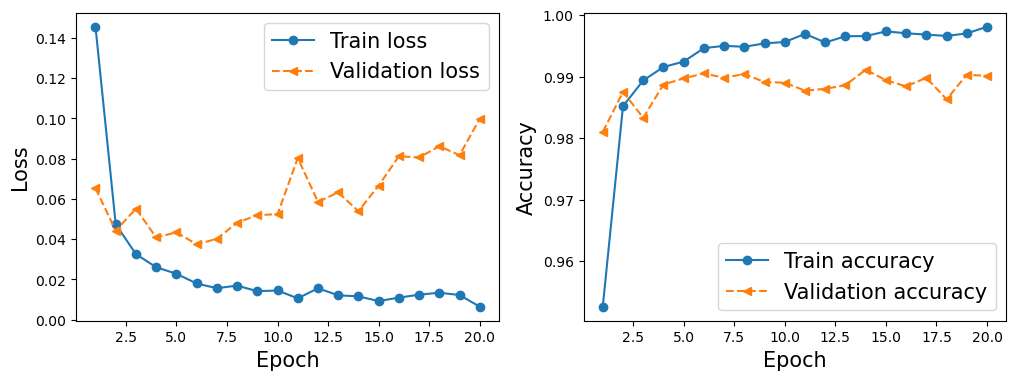

In [67]:
import matplotlib.pyplot as plt
hist_cp = hist
hist = (
    hist[0],
    hist[1],
    list(map(lambda el: el.to("cpu"), hist[2])),
    list(map(lambda el: el.to("cpu"), hist[3])),
)
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist[0],'-o',label='Train loss')
ax.plot(x_arr, hist[1],'--<',label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel("Epoch",size=15)
ax.set_ylabel("Loss",size=15)
ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist[2],'-o',label='Train accuracy')
ax.plot(x_arr, hist[3],'--<',label='Validation accuracy')
ax.legend(fontsize=15)
ax.set_xlabel("Epoch",size=15)
ax.set_ylabel("Accuracy",size=15)
plt.show()

In [71]:
model = model.to("cpu")
pred = model(mnist_test_dataset.data.unsqueeze(1).to("cpu")/255)
is_correct = (torch.argmax(pred,dim=1) == mnist_test_dataset.targets.to("cpu")).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9918


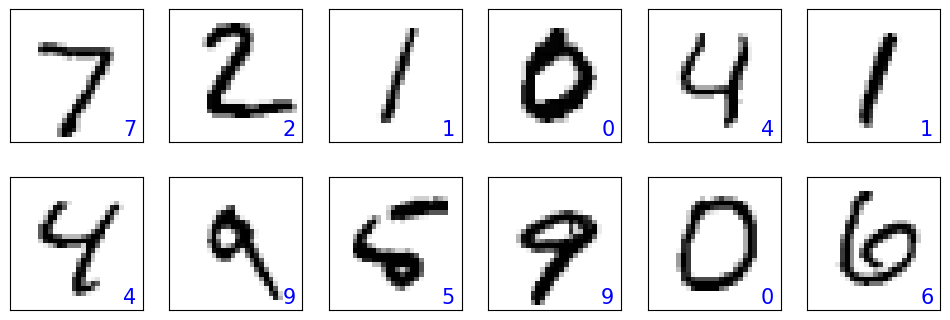

In [72]:
fig = plt.figure(figsize=(12,4))
for i in range(12):
    ax = fig.add_subplot(2,6,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    img = mnist_test_dataset[i][0][0,:,:]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(
        0.9,
        0.1,
        y_pred.item(),
        size=15,
        color="blue",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes
    )
plt.show()

# Smile classification from face images using a CNN

In [73]:
image_path = "../NNs with PyTorch/"
celeba_train_dataset = torchvision.datasets.CelebA(image_path,split='train',target_type='attr',download=False)
celeba_valid_dataset = torchvision.datasets.CelebA(image_path,split='valid',target_type='attr',download=False)
celeba_test_dataset = torchvision.datasets.CelebA(image_path,split='test',target_type='attr',download=False)
print('Train set: ',len(celeba_train_dataset))
print('Valid set: ',len(celeba_valid_dataset))
print('Test set: ',len(celeba_test_dataset))

Train set:  162770
Valid set:  19867
Test set:  19962


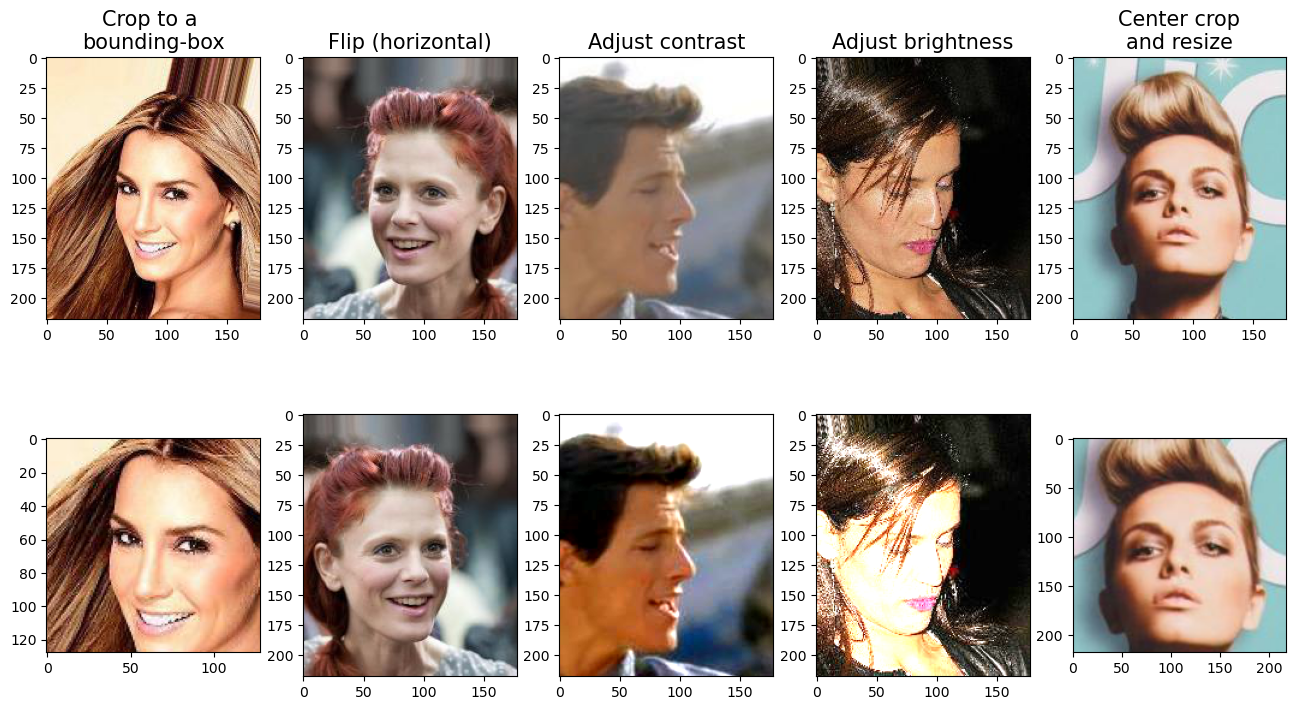

In [75]:
import torchvision.transforms.v2.functional as F

fig = plt.figure(figsize=(16,8.5))

ax = fig.add_subplot(2,5,1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,6)
img_cropped = F.crop(img,50,20,128,128)
ax.imshow(img_cropped)

ax = fig.add_subplot(2,5,2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,7)
img_flipped = F.hflip(img)
ax.imshow(img_flipped)

ax = fig.add_subplot(2,5,3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust contrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,8)
img_adj_contrast = F.adjust_contrast(img,contrast_factor=2)
ax.imshow(img_adj_contrast)

ax = fig.add_subplot(2,5,4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,9)
img_adj_brightness = F.adjust_brightness(img,brightness_factor=2)
ax.imshow(img_adj_brightness)

ax = fig.add_subplot(2,5,5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2,5,10)
img_center_cropped = F.center_crop(img,[0.7*218,0.7*218])
img_resized = F.resize(img_center_cropped,size=(218,218))
ax.imshow(img_resized)

plt.show()

In [89]:
get_smile = lambda attr: attr[31]

transform_train = transforms.Compose([
    transforms.RandomCrop([178,178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64,64]),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32,True)
])

transform = transforms.Compose([
    transforms.CenterCrop([178,178]),
    transforms.Resize([64,64]),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32,True)
])

torch.manual_seed(1)
celeba_train_dataset = torchvision.datasets.CelebA(
    image_path,split='train',target_type='attr',download=False,transform=transform_train,target_transform=get_smile
)
celeba_valid_dataset = torchvision.datasets.CelebA(
    image_path,split='valid',target_type='attr',download=False,transform=transform,target_transform=get_smile
)
celeba_test_dataset = torchvision.datasets.CelebA(
    image_path,split='test',target_type='attr',download=False,transform=transform,target_transform=get_smile
)

In [90]:
celeba_train_dataset = Subset(celeba_train_dataset,torch.arange(16000))
celeba_valid_dataset = Subset(celeba_valid_dataset,torch.arange(1000))

In [91]:
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(celeba_train_dataset,batch_size,True)
valid_dl = DataLoader(celeba_valid_dataset,batch_size,False)
test_dl = DataLoader(celeba_test_dataset,batch_size,False)

In [92]:
model = nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Conv2d(32,64,3,padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Dropout(0.5),
    nn.Conv2d(64,128,3,padding=1),
    nn.LeakyReLU(0.1),
    nn.MaxPool2d(2),
    nn.Conv2d(128,256,3,padding=1),
    nn.LeakyReLU(0.1),
    nn.AvgPool2d(8),
    nn.Flatten(),
    nn.Linear(256,1),
    nn.Sigmoid()
).to("mps")
model(torch.ones((4,3,64,64)).to("mps")).shape

torch.Size([4, 1])

In [93]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [94]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accu_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accu_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch, y_batch = x_batch.to("mps"), y_batch.to("mps")
            pred = model(x_batch)[:,0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accu_hist_train[epoch] += is_correct.sum().item()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accu_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch, y_batch = x_batch.to("mps"), y_batch.to("mps")
                pred = model(x_batch)[:,0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred>=0.5).float() == y_batch).float()
                accu_hist_valid[epoch] += is_correct.sum().item()
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accu_hist_valid[epoch] /= len(valid_dl.dataset)

        print(
            f"Epoch {epoch+1} accuracy: {accu_hist_train[epoch]:.4f}; val accuracy: {accu_hist_valid[epoch]:.4f}"
        )

    return loss_hist_train, loss_hist_valid, accu_hist_train, accu_hist_valid

In [95]:
torch.manual_seed(1)
num_epochs = 30
hist = train(model,num_epochs,train_dl,valid_dl)

Epoch 1 accuracy: 0.5242; val accuracy: 0.5680
Epoch 2 accuracy: 0.5476; val accuracy: 0.5670
Epoch 3 accuracy: 0.5781; val accuracy: 0.5570
Epoch 4 accuracy: 0.6155; val accuracy: 0.6270
Epoch 5 accuracy: 0.6391; val accuracy: 0.5850
Epoch 6 accuracy: 0.6553; val accuracy: 0.6490
Epoch 7 accuracy: 0.6865; val accuracy: 0.7160
Epoch 8 accuracy: 0.7439; val accuracy: 0.7530
Epoch 9 accuracy: 0.7977; val accuracy: 0.7770
Epoch 10 accuracy: 0.8299; val accuracy: 0.8390
Epoch 11 accuracy: 0.8466; val accuracy: 0.8730
Epoch 12 accuracy: 0.8586; val accuracy: 0.8790
Epoch 13 accuracy: 0.8682; val accuracy: 0.8710
Epoch 14 accuracy: 0.8731; val accuracy: 0.8840
Epoch 15 accuracy: 0.8778; val accuracy: 0.8880
Epoch 16 accuracy: 0.8814; val accuracy: 0.8900
Epoch 17 accuracy: 0.8843; val accuracy: 0.8880
Epoch 18 accuracy: 0.8862; val accuracy: 0.8950
Epoch 19 accuracy: 0.8871; val accuracy: 0.8940
Epoch 20 accuracy: 0.8911; val accuracy: 0.9040
Epoch 21 accuracy: 0.8922; val accuracy: 0.9030
E

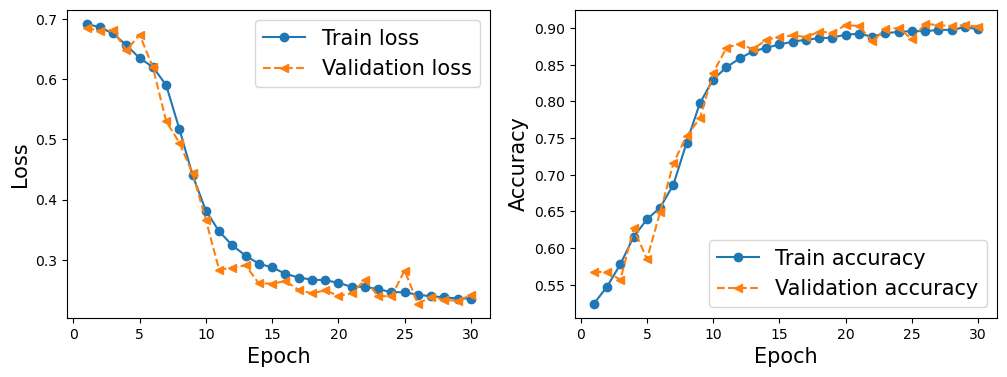

In [96]:
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], "-o", label="Train loss")
ax.plot(x_arr, hist[1], "--<", label="Validation loss")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], "-o", label="Train accuracy")
ax.plot(x_arr, hist[3], "--<", label="Validation accuracy")
ax.legend(fontsize=15)
ax.set_xlabel("Epoch", size=15)
ax.set_ylabel("Accuracy", size=15)
plt.show()

In [98]:
accuracy_test = 0
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch, y_batch = x_batch.to("mps"), y_batch.to("mps")
        pred = model(x_batch)[:,0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().item()
accuracy_test /= len(test_dl.dataset)
print(f"Test accuracy: {accuracy_test:.4f}")

Test accuracy: 0.9101


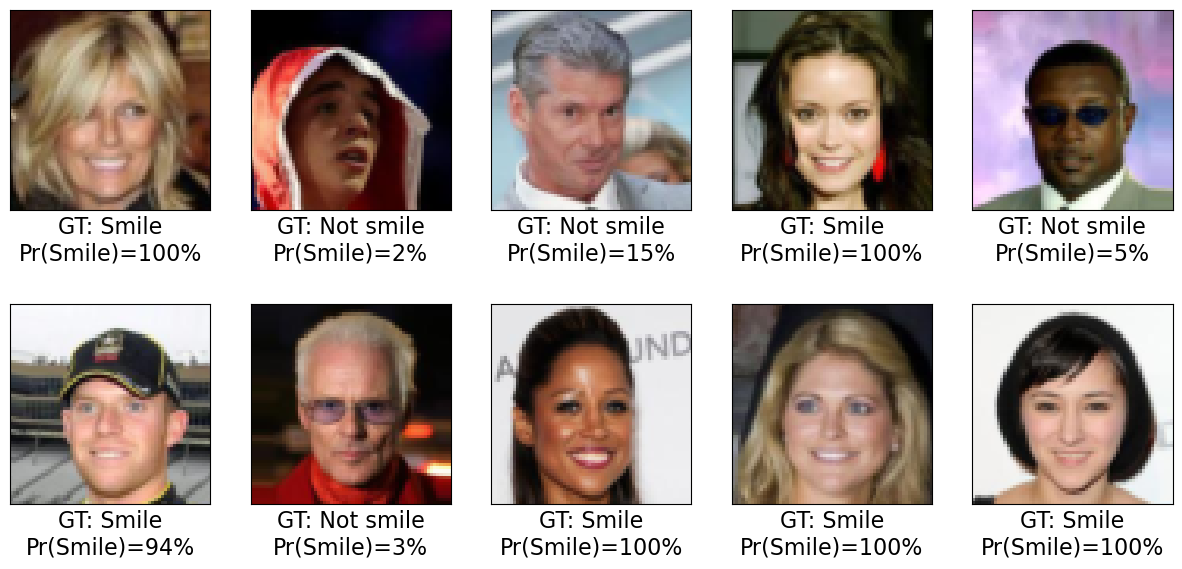

In [101]:
pred = (model(x_batch)[:,0]*100).to("cpu")
fig = plt.figure(figsize=(15,7))
for j in range(10,20):
    ax = fig.add_subplot(2,5,j-10+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1,2,0).to("cpu"))

    label = "Not smile"
    if y_batch[j] == 1:
        label = "Smile"
    
    ax.text(
        0.5,-0.15,
        f"GT: {label:s}\nPr(Smile)={pred[j]:.0f}%",
        size=16,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes
    )
plt.show()